### Dyna Q implementation

First Learning Q learning , then to Dyna Q

In [ ]:
# First Create a simple grid world

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

class GridWorldEnv:
    def __init__(self, grid_size =(5,5), start = (0,0), goal =(4,4), walls = None):
        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.walls = walls if walls else []

        self.action_map = {
            0: (-1,0), # up
            1: (1,0) , # down
            2: (0,-1), # left
            3: (0,1)   # right
        }
        # # Create figure once and reuse it
        # self.fig, self.ax = plt.subplots(figsize=(6, 6))
        # plt.ion()  # Turn on interactive mode
        self.reset()

    def reset(self):
        self.agent_pos = list(self.start) # a list [0,0]
        return tuple(self.agent_pos) # (0,0)

    def step(self, action):
        move = self.action_map[action]
        new_pos = [self.agent_pos[0] + move[0], self.agent_pos[1] + move[1]]

        # Boundary check
        new_pos[0] = max(0, min(self.grid_size[0] - 1, new_pos[0]))
        new_pos[1] = max(0, min(self.grid_size[1] - 1, new_pos[1]))

        # Wall check : if next cell is a wall , stay in place
        if tuple(new_pos) not in self.walls:
            self.agent_pos = new_pos

        done = (tuple(self.agent_pos) == self.goal)
        reward = 1 if done else -0.01

        return tuple(self.agent_pos), reward, done

    def render(self, last_action=None):
        if not hasattr(self, 'fig') or not hasattr(self, 'ax'):
            self.fig, self.ax = plt.subplots(figsize=(6, 6))
            plt.ion()

        # Clear the current axes
        self.ax.clear()

        # Create grid visualization
        grid = np.zeros(self.grid_size)
        grid[self.goal] = 0.8  # Goal position

        self.ax.imshow(grid, cmap='gray', origin='lower', vmin=0, vmax=1)

        # Draw walls
        for wy, wx in self.walls:
            self.ax.add_patch(plt.Rectangle((wx - 0.5, wy - 0.5), 1, 1, color='dimgray'))


        # Grid lines
        for i in range(self.grid_size[0] + 1):
            self.ax.axhline(i - 0.5, color='white', linewidth=1)
        for j in range(self.grid_size[1] + 1):
            self.ax.axvline(j - 0.5, color='white', linewidth=1)

        # set up axis labels and ticks
        self.ax.set_xticks(range(self.grid_size[1]))
        self.ax.set_yticks(range(self.grid_size[0]))
        self.ax.set_xticklabels(range(self.grid_size[1]))
        self.ax.set_yticklabels(range(self.grid_size[0]))


        # Agent visualization
        y, x = self.agent_pos

        if last_action is not None:
            # Show arrow for last action
            dx, dy = {
                0: (0, -0.3),   # up
                1: (0, 0.3),    # down
                2: (-0.3, 0),   # left
                3: (0.3, 0),    # right
            }[last_action]
            self.ax.arrow(x, y, dx, dy, head_width=0.15, head_length=0.15,
                         fc='red', ec='red', linewidth=2)

        # Always show agent position as a circle
        self.ax.plot(x, y, 'bo', markersize=12, markeredgecolor='white', markeredgewidth=2)

        # Mark goal
        goal_x, goal_y = self.goal[1], self.goal[0]
        self.ax.plot(goal_x, goal_y, 'g*', markersize=20, markeredgecolor='black', markeredgewidth=1)

        self.ax.set_title(f"GridWorld - Agent at {self.agent_pos}", fontsize=14, fontweight='bold')
        self.ax.set_xlim(-0.5, self.grid_size[1] - 0.5)
        self.ax.set_ylim(-0.5, self.grid_size[0] - 0.5)

        # Add axis labels
        self.ax.set_xlabel('X (Column)', fontsize=12)
        self.ax.set_ylabel('Y (Row)', fontsize=12)

        # Update the display
        clear_output(wait=True)
        display(self.fig)

    def close(self):
        """Close the figure when done"""
        plt.close(self.fig)


# Q value update map
def plot_q_table_heatmap(Q, env):
    max_Q = np.max(Q, axis=2)  # shape = (rows, cols)

    fig, ax = plt.subplots(figsize=(6, 6))
    c = ax.imshow(max_Q, cmap='viridis', origin='upper')

    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            q_val = max_Q[i, j]
            ax.text(j, i, f"{q_val:.2f}", va='center', ha='center', color='white', fontsize=8)

    ax.set_title("Max Q-value per State")
    ax.set_xticks(np.arange(env.grid_size[1]))
    ax.set_yticks(np.arange(env.grid_size[0]))
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    fig.colorbar(c, ax=ax)
    # plt.gca().invert_yaxis()
    plt.show()


# Testing the Gridworl environment

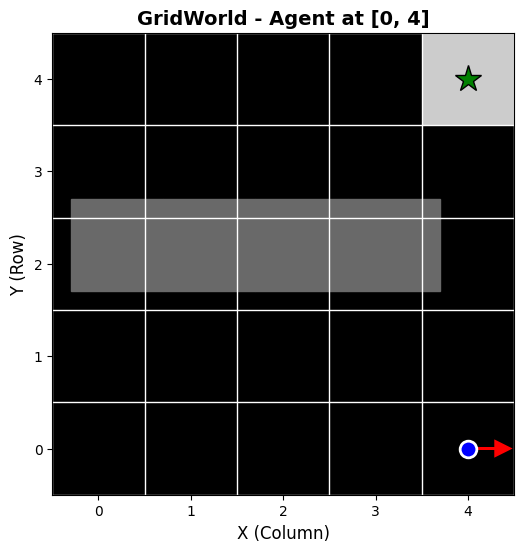

In [ ]:
%matplotlib inline
walls = [(2, i) for i in range(5)]  # entire row 2 is blocked
walls.remove((2, 4))  # leave one gap at (2,4)

env = GridWorldEnv(walls=walls)
state = env.reset()
env.render()

for step in range(10):
  action = np.random.randint(0,4) # 0-3 actions
  next_state, reward, done = env.step(action)
  print(f"Step {step+1}: Action={action}, Position={next_state}, Reward={reward}")
  env.render(last_action=action)
  time.sleep(0.5)

  if done:
    print("Goal reached")
    break

env.close()

# Define Q table, epsilon greedy policy

In [ ]:
# Environment setup
env = GridWorldEnv()
state_shape = env.grid_size
num_action = 4

# Lets first define the 3D Q matrix or Q table, Q[s, a] => Q[state_row, state_col, action]
Q = np.zeros((state_shape[0], state_shape[1], num_action)) # This sets up a Q-value for each (state, action) pair.

# Implement Epsilon greedy action selection
def choose_action(state, Q, Epsilon):
    """
    Given Q[state_row, state_row,:] and E , choose action with probabilty E, and random action with Probability 1 - E
    """
    if np.random.rand() < Epsilon:
        return np.random.randint(4) # Exploration
    else:
        row, col = state
        return np.argmax(Q[row, col]) # Greedy action = Exploitation


# Define Hyperparameters


In [ ]:
alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon = 0.2 # exploration rate
num_episodes = 100
max_steps = 100

# Implement Q learning update
"what is the best action to take from any state to eventually get the most reward"

Goal:  
Learn the optimal action-value function Q(s, a), which estimates the expected cumulative reward when taking action a in state s, and following the optimal policy thereafter.

Update Equation:

  Q(s, a) ← Q(s, a) + α [ r + γ * max_a' Q(s', a') - Q(s, a) ]

Where:
- s, a : Current state and action  
- r    : Reward received  
- s'   : Next state after action a  
- α    : Learning rate  
- γ    : Discount factor  
- max_a' Q(s', a') : Estimated optimal future value from next state

Explanation:  
At each time step, the Q-value is updated using 1-step Temporal Difference (TD) learning.  
It shifts the current estimate Q(s, a) toward the more accurate target value r + γ * max_a' Q(s', a').



Episode 0


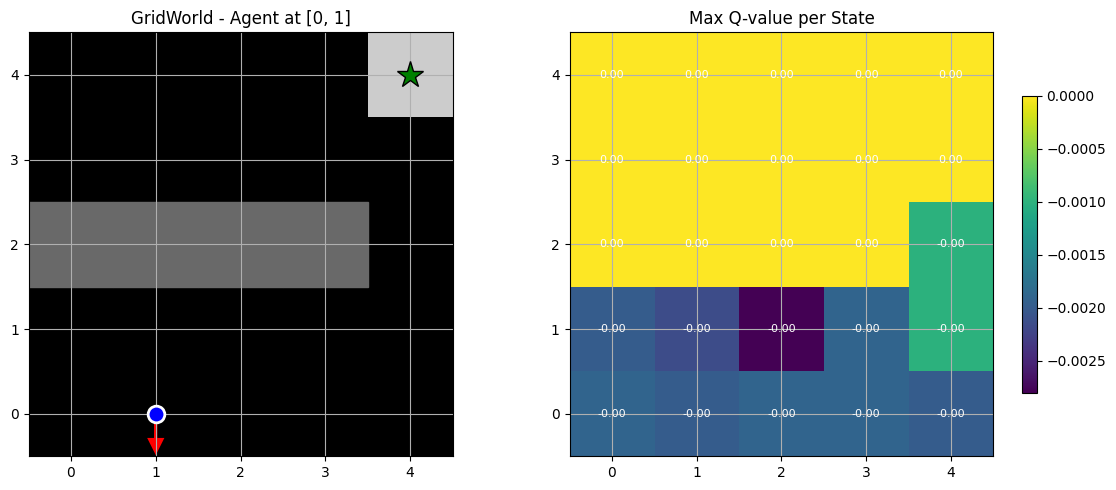

NameError: name 'step' is not defined

In [ ]:
walls = [(2,i) for i in range(5)]
walls.remove((2,4))
env = GridWorldEnv(walls=walls)
state_shape = env.grid_size
num_action = 4
Q = np.zeros((state_shape[0],state_shape[1], num_action))

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    for steps in range(max_steps):
        action = choose_action(state, Q, epsilon)
        next_state, reward, done = env.step(action)

        # unpack state coordinates
        row, col = state
        next_row, next_col = next_state

        # Q - learning update
        best_next_action = np.argmax(Q[next_row, next_col])
        td_target = reward + gamma * Q[next_row, next_col, best_next_action]
        td_error = td_target - Q[row, col, action]
        Q[row, col, action] += alpha*td_error

        # Update state
        state = next_state
        total_reward += reward

        if episode % 10 == 0:
            clear_output(wait=True)
            print(f"Episode {episode}")

            # Setup combined figure
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # LEFT: Agent grid
            axes[0].set_title(f"GridWorld - Agent at {env.agent_pos}")
            grid = np.zeros(env.grid_size)
            grid[env.goal] = 0.8
            axes[0].imshow(grid, cmap='gray', origin='upper', vmin=0, vmax=1)
            # Draw walls manually
            for wy, wx in env.walls:
                axes[0].add_patch(plt.Rectangle((wx - 0.5, wy - 0.5), 1, 1, color='dimgray'))


            # Agent + goal rendering
            y, x = env.agent_pos
            dx, dy = {
                0: (0, -0.3), 1: (0, 0.3), 2: (-0.3, 0), 3: (0.3, 0)
            }.get(action, (0, 0))
            axes[0].arrow(x, y, dx, dy, head_width=0.15, head_length=0.15, fc='red', ec='red', linewidth=2)
            axes[0].plot(x, y, 'bo', markersize=12, markeredgecolor='white', markeredgewidth=2)
            goal_x, goal_y = env.goal[1], env.goal[0]
            axes[0].plot(goal_x, goal_y, 'g*', markersize=20, markeredgecolor='black', markeredgewidth=1)

            # Grid formatting
            for ax in axes:
                ax.set_xticks(range(env.grid_size[1]))
                ax.set_yticks(range(env.grid_size[0]))
                ax.set_xticklabels(range(env.grid_size[1]))
                ax.set_yticklabels(range(env.grid_size[0]))
                ax.set_xlim(-0.5, env.grid_size[1]-0.5)
                ax.set_ylim(-0.5, env.grid_size[0]-0.5)
                ax.grid(True)

            # RIGHT: Q-value heatmap
            max_Q = np.max(Q, axis=2)
            im = axes[1].imshow(max_Q, cmap='viridis', origin='upper')
            axes[1].set_title("Max Q-value per State")
            for i in range(env.grid_size[0]):
                for j in range(env.grid_size[1]):
                    q_val = max_Q[i, j]
                    axes[1].text(j, i, f"{q_val:.2f}", va='center', ha='center', color='white', fontsize=8)
            fig.colorbar(im, ax=axes[1], shrink=0.7)

            plt.tight_layout()
            plt.show()
            # time.sleep(0.5)


        if done:
            print(f" Episode {episode +1} finished in {step +1} steps. Total reward : {total_reward}")
            break

env.close()


# Visualize the Best Path after Q learning update

In [ ]:
def visualize_greedy_path(Q, env, max_steps=50):
    state = env.reset() # move to initial state
    path = [state] # list of tuples
    actions = []

    for _ in range(max_steps):
        row , col = state
        action = np.argmax(Q[row, col])
        actions.append(action)

        next_state , _ , done = env.step(action)
        path.append(next_state)
        state = next_state
        if done:
            break

    # Now plot the full path
    fig, ax = plt.subplots(figsize=(6, 6))
    grid = np.zeros(env.grid_size)
    grid[env.goal] = 0.8
    ax.imshow(grid, cmap='gray', origin='lower', vmin=0, vmax=1)
    ax.set_title("Greedy Path from Start to Goal")

    for idx, (pos, action) in enumerate(zip(path[:-1], actions)):
        y, x = pos
        dx, dy = {
            0: (0, -0.3), 1: (0, 0.3), 2: (-0.3, 0), 3: (0.3, 0)
        }[action]
        ax.arrow(x, y, dx, dy, head_width=0.15, head_length=0.15,
                 fc='blue', ec='blue', linewidth=2)

    # Start and Goal
    sx, sy = path[0][1], path[0][0]
    gx, gy = env.goal[1], env.goal[0]
    ax.plot(sx, sy, 'bo', markersize=12, markeredgecolor='white', markeredgewidth=2, label='Start')
    ax.plot(gx, gy, 'g*', markersize=20, markeredgecolor='black', markeredgewidth=1, label='Goal')

    ax.set_xlim(-0.5, env.grid_size[1] - 0.5)
    ax.set_ylim(-0.5, env.grid_size[0] - 0.5)
    ax.set_xticks(range(env.grid_size[1]))
    ax.set_yticks(range(env.grid_size[0]))
    ax.set_xticklabels(range(env.grid_size[1]))
    ax.set_yticklabels(range(env.grid_size[0]))
    ax.grid(True)
    ax.legend()
    plt.show()

# Plot steps per episode vs episodes
def steps_per_episode_plot(steps_per_episode):
    plt.figure(figsize=(10, 5))
    plt.plot(steps_per_episode, label='Steps per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.title('Dyna-Q Learning: Steps per Episode')
    plt.grid(True)
    plt.legend()
    plt.show()

# visualize_greedy_path(Q, env)

In [ ]:
def render_dyna_q(env, agent, episode, action):
    clear_output(wait=True)
    print(f"Episode {episode}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # === LEFT: Gridworld ===
    axes[0].set_title(f"Dyna-Q: Agent at {env.agent_pos}")
    grid = np.zeros(env.grid_size)
    grid[env.goal] = 0.8
    axes[0].imshow(grid, cmap='gray', origin='upper', vmin=0, vmax=1)

    # Draw walls
    for wy, wx in env.walls:
        axes[0].add_patch(plt.Rectangle((wx - 0.5, wy - 0.5), 1, 1, color='dimgray'))

    # Agent arrow + circle

    y, x = env.agent_pos
    if 'action' in locals():
      dx, dy = {
          0: (0, -0.3), 1: (0, 0.3), 2: (-0.3, 0), 3: (0.3, 0)
      }.get(action, (0, 0))
      axes[0].arrow(x, y, dx, dy, head_width=0.15, head_length=0.15, fc='red', ec='red', linewidth=2)
      axes[0].plot(x, y, 'bo', markersize=12, markeredgecolor='white', markeredgewidth=2)

    # Goal
    goal_x, goal_y = env.goal[1], env.goal[0]
    axes[0].plot(goal_x, goal_y, 'g*', markersize=20, markeredgecolor='black', markeredgewidth=1)

    # Grid formatting
    for ax in axes:
        ax.set_xticks(range(env.grid_size[1]))
        ax.set_yticks(range(env.grid_size[0]))
        ax.set_xticklabels(range(env.grid_size[1]))
        ax.set_yticklabels(range(env.grid_size[0]))
        ax.set_xlim(-0.5, env.grid_size[1] - 0.5)
        ax.set_ylim(-0.5, env.grid_size[0] - 0.5)
        ax.grid(True)

    # === RIGHT: Q-table ===
    max_Q = np.max(agent.Q, axis=2)
    im = axes[1].imshow(max_Q, cmap='viridis', origin='upper')
    axes[1].set_title("Max Q-value per State")
    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            q_val = max_Q[i, j]
            axes[1].text(j, i, f"{q_val:.2f}", va='center', ha='center', color='white', fontsize=8)

    fig.colorbar(im, ax=axes[1], shrink=0.7)
    plt.tight_layout()
    plt.show()

# Dyna Q => Q Learning + Planning

## for each Q learning steps , we do multiple planning steps

here we consider a Deterministic model (instead of full probabilisty bellman model) for planning, update
this simple model store all the State action and maps to next action and reward.

###Planning:
We simulate experience by randomly sampling from the stored state-action pairs,  
and apply the same Q-learning TD update to those simulated transitions.

Why random sampling instead of starting from starting position ?
* If we always started from the beginning:
  * We’d waste planning steps on a *small number of state-action pairs*, possibly ignoring other useful transitions the agent already visited.
  * In complex environments, starting only from the beginning won’t reach the parts of the space that matter, especially if the change happened far away from the start
* Random sampling was one simple way to spread planning across the space

**Key Advantage:**  
Faster learning cause of direct experience + internal simulation (planning).

In [ ]:
import random

class DynaQAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, planning_steps=5) -> None:
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.planning_steps = planning_steps

        self.Q = np.zeros((env.grid_size[0], env.grid_size[1], 4 ))
        self.model = {} # for planning : Deterministic Sample Model

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(4)
        else:
            action = np.argmax(self.Q[state[0], state[1]])
        return action

    def update_real(self, state, action, reward, next_state):
        # 1 step Q learning update
        if next_state is None:
            td_target = reward # Terminal state
        else:
            best_action = np.argmax(self.Q[next_state[0], next_state[1]])
            td_target = reward + self.gamma * self.Q[next_state[0], next_state[1], best_action]

        td_error = td_target - self.Q[state[0],state[1], action]
        self.Q[state[0],state[1], action] += self.alpha * td_error

    def update_model(self, state, action, reward, next_state):
        self.model[(state, action)] = next_state, reward

    def planning(self):
        if not self.model: # only do planning if we have experience to learn
            return
        for _ in range(self.planning_steps):
            state , action = random.choice(list(self.model.keys()))
            next_state, reward = self.model[(state, action)]

            if next_state is None:
                continue
            self.update_real(state, action, reward, next_state)

In [ ]:
# Training loop
def train_dyna_q(env, planning_steps, num_episodes=100, max_steps=300,gamma=0.95 ,visualize=False):
    agent = DynaQAgent(env, alpha=0.1, gamma=gamma, epsilon=0.1, planning_steps=planning_steps)
    steps_per_episode = []
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = agent.choose_action(state)
            next_state , reward, done = env.step(action)

            agent.update_real(state, action, reward, next_state)
            if not done: # Only update model with non terminal state
                agent.update_model(state, action, reward, next_state)
            else:
                agent.update_model(state, action, reward, None)

            agent.planning()

            total_reward += reward
            state = next_state
            if done:
                rewards_per_episode.append(total_reward)
                steps_per_episode.append(step + 1)
                break
        else:
            steps_per_episode.append(max_steps) # only append if loop completes without break


        # Visualization for Dyna Q -> move this inner forloop, this will slowdown the training, need to update better visualization
        if visualize and episode % 10 == 0:
            render_dyna_q(env, agent, episode, action)

    return steps_per_episode,  rewards_per_episode ,agent



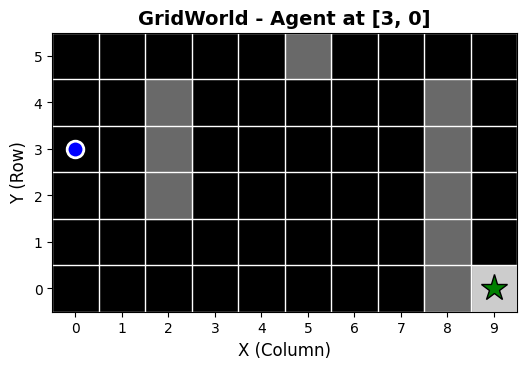

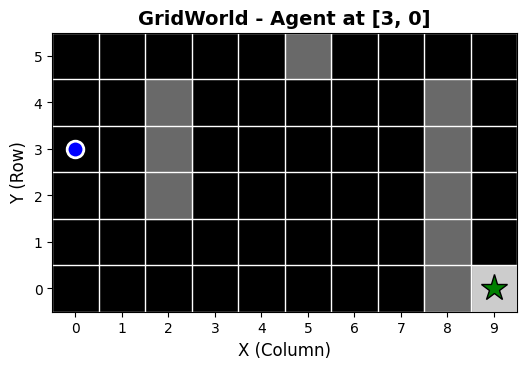

In [ ]:
walls = [(2, 2), (3, 2), (4, 2),
          (5, 5),
         (0,8),(1, 8),(2,8),(3,8) ,(4, 8)]
env = GridWorldEnv(grid_size=(6,10), start=(3,0), goal=(0,9), walls=walls)
env.render()

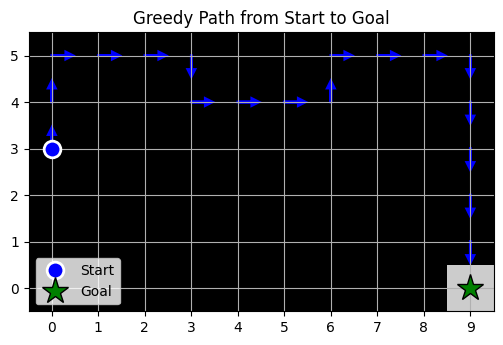

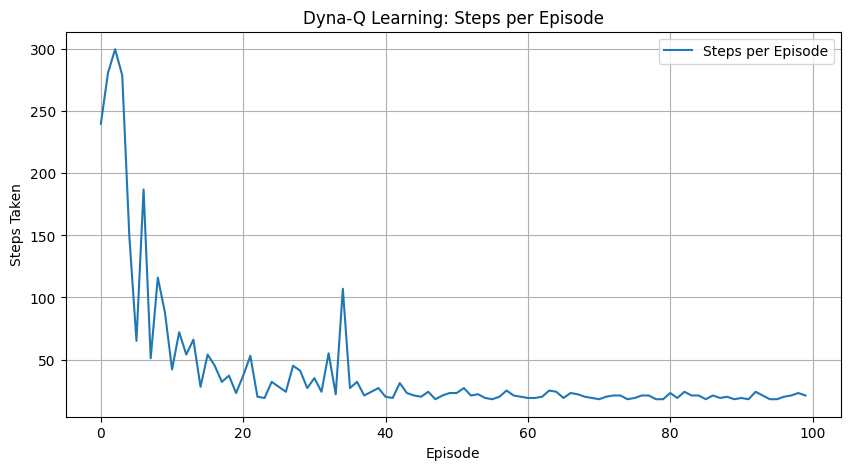

In [ ]:
step_per_episode,_ , agent = train_dyna_q(env, planning_steps=5, num_episodes=100, visualize=False)
visualize_greedy_path(agent.Q, env)
steps_per_episode_plot(step_per_episode)

In [ ]:
walls = [(2, 2), (3, 2), (4, 2),
          (5, 5),
         (0,8),(1, 8),(2,8),(3,8) ,(4, 8)]
# env = GridWorldEnv(grid_size=(6,10), start=(3,0), goal=(0,9), walls=walls)
results = {}
for p in [0, 5, 50]:
    env = GridWorldEnv(grid_size=(6,10), start=(3,0), goal=(0,9), walls=walls)
    steps, _,_ = train_dyna_q(env, planning_steps=p, num_episodes=100, max_steps=1000,visualize=False)
    results[p] = steps

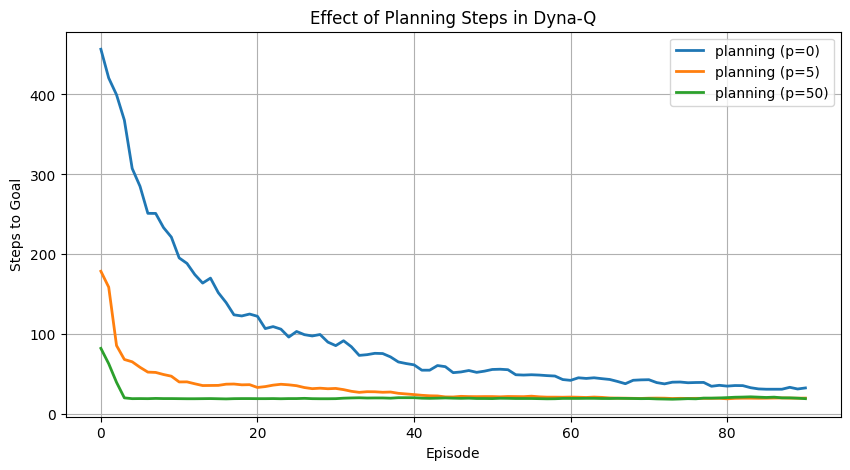

In [ ]:
# walls = [
#     [(2,0),(2,1),(2,2),(2, 3), (2, 4), (2, 5),(2, 6),(2, 7),(2, 8)],
#  [(2,1),(2,2),(2, 3), (2, 4), (2, 5),(2, 6),(2, 7),(2, 8),(2,9)]]
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10,5))
for p, steps in results.items():
    # plt.plot(steps, label=f'Planning Steps = {p}')
    smoothed = moving_average(steps, window_size=10)
    plt.plot(range(len(smoothed)), smoothed, label=f'planning (p={p})', linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Steps to Goal")
plt.title("Effect of Planning Steps in Dyna-Q")
plt.legend()
plt.grid(True)
plt.show()

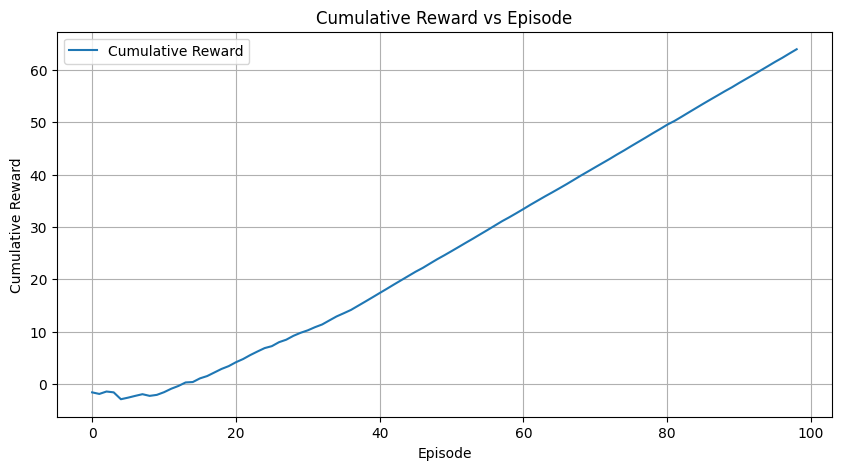

In [ ]:
# Cummulative reward vs Time steps
def plot_rewards(rewards_per_episode):
    cumulative_rewards = np.cumsum(rewards_per_episode)
    timesteps = np.arange(len(cumulative_rewards))

    plt.figure(figsize=(10,5))
    plt.plot(timesteps, cumulative_rewards, label='Cumulative Reward')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward vs Episode")
    plt.grid(True)
    plt.legend()
    plt.show()

steps, rewards, agent = train_dyna_q(env, planning_steps=5, num_episodes=100, visualize=False)
plot_rewards(rewards)


# Observsation : Cummulative reward vs Timesteps

In early episodes, the agent gets low or negative reward (mostly -0.01 per step, maybe not reaching the goal).

Once learning improves (say, from episode ~20 onward), it starts reaching the goal more often, collecting positive rewards (+1), which lifts the curve steadily.

The linear upward trend later on indicates the agent is consistently reaching the goal quickly — learning has stabilized.


In [ ]:
# Now lets change the environment :
initial_walls = [
    (2,0),(2,1),(2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8)
]
changed_walls = [
    (2,1),(2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8),(2,9)
]
# Modify the training loop to change the wall after episode 40
def train_dyna_q_changing_walls(env,
                                planning_steps,
                                num_episodes=100,
                                max_steps=300,
                                gamma=0.95,
                                visualize=False,
                                agent_cls = None,
                                **agent_kwargs):
    agent_cls = agent_cls or DynaQAgent
    agent = agent_cls(env, alpha=0.1, gamma=gamma, epsilon=0.1, planning_steps=planning_steps,
                      **agent_kwargs)
    steps_per_episode ,rewards_per_episode = [], []

    for episode in range(num_episodes):
        if episode == 40:
            # Change walls mid-training
            env.walls = changed_walls
            print("Environment changed at episode 40")

        state , total_reward = env.reset(), 0

        for step in range(max_steps):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)

            agent.update_real(state, action, reward, next_state)
            if not done:
                agent.update_model(state, action, reward, next_state)
            else:
                agent.update_model(state, action, reward, None)

            agent.planning()
            total_reward += reward
            state = next_state

            if done:
                steps_per_episode.append(step + 1)
                rewards_per_episode.append(total_reward)
                break
        else:
            steps_per_episode.append(max_steps)
            rewards_per_episode.append(total_reward)

        if visualize and episode % 10 == 0:
            render_dyna_q(env, agent, episode, action)

    return steps_per_episode, rewards_per_episode, agent



Environment changed at episode 40


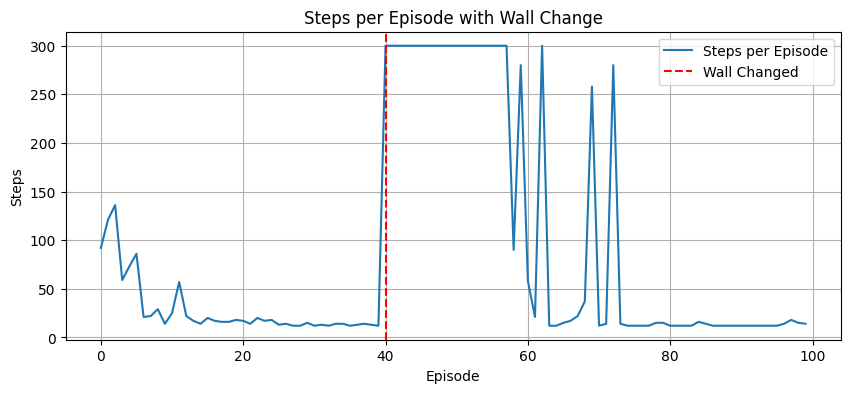

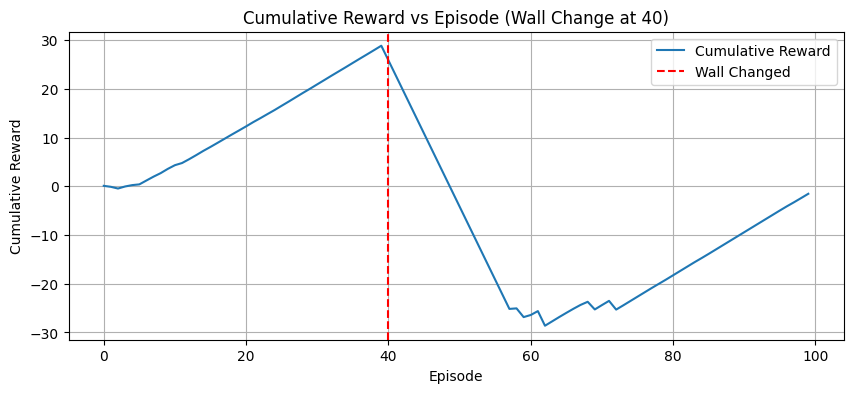

In [ ]:
steps, rewards, agent = train_dyna_q_changing_walls(
    GridWorldEnv(grid_size=(6,10), start=(3,0), goal=(0,9), walls=initial_walls),
    planning_steps=5,
    num_episodes=100,
    visualize=False
)

# Plot Steps
plt.figure(figsize=(10, 4))
plt.plot(steps, label="Steps per Episode")
plt.axvline(x=40, color='red', linestyle='--', label='Wall Changed')
plt.title("Steps per Episode with Wall Change")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.grid(True)
plt.legend()
plt.show()

# Plot Cumulative Rewards
cumulative_rewards = np.cumsum(rewards)
plt.figure(figsize=(10, 4))
plt.plot(cumulative_rewards, label="Cumulative Reward")
plt.axvline(x=40, color='red', linestyle='--', label='Wall Changed')
plt.title("Cumulative Reward vs Episode (Wall Change at 40)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.legend()
plt.show()


## The Need of DynaQ+

```
  But what happens if the world changes?
```
We just saw that if the env changes ,DynaQ takes time to find the next path way. we solve this problem by giving more bonus varying reward to unseen or old visited state, action pairs in planning phase.

Dyna-Q assumes the world is stationary — once it learns a model, it keeps replaying it during planning.
But what happens if the world changes?

The agent keeps planning from outdated experiences, even if those transitions are no longer valid.

This makes it slow to adapt to environment changes — especially if those old transitions are still reinforced during planning.

* It has no built-in mechanism to "forget" outdated knowledge.

* It tends to exploit the known transitions in planning again and again — even if they’re no longer good in reality.

* While Dyna-Q does learn eventually (via exploration), its model doesn’t prioritize exploration of less visited areas.
```
Why not simply increase epsilon in epsilon greedy to explore more ?
```
Increasing ε in ε-greedy:

* Makes the agent explore randomly during real experience (i.e. actual steps in the environment).

* But it does not affect planning (i.e. simulated updates from the model).

* And it is uniformly random — it doesn’t prioritize trying unexplored or outdated transitions.

In DynaQ+ , it keep the same epsilon for real experience.
but But adds a targeted exploration bonus during planning updates only.

* for each stored transition(s,a,s_dash, r) , DynaQ+ computes ▶
  * adjusted reward = r + k . sqrt(t(s,a))
  here:
    * t(s,a) : how long its been since that (state,action) was tried in real env.
    * k : A small scaling factor

  * This reward is added more to those **that have not been visited recently**
    * extra reward is small : if recently visited
    * extra reward is large : if is not visited recently

* Now planning is now biased to simulate transition that haven't tried in a while
* if the env has changed, those outdated transition may now become valuable

    ```
    Q(s,a) = Q(s,a) + a. [ r + k.sqrt(t) + gamma. maxQ(s_dash, a_dash) - Q(s,a)]
    ```
```
How do we track t(s,a) ?
```
we maintain a dictionary or 2D array, and store the time when the agent picks that state and action.
* time_since_visited = defaultdict(lambda: 0)
Each time we perform a real interaction ,
  * increment a global counter
  * for S,A : set ➡ time_last_visted[(s,a)] = current_time
  * compute t(s,a) = current_time - time_last_visited[(s,a)]


* ε-greedy: "Let’s roll a dice and try something random just in case it’s good."
* Dyna-Q+: "Hey, I haven’t checked that room in a long time… maybe something changed there — let me simulate it again."

In [ ]:
import numpy as np
import random
from collections import defaultdict


class DynaQPlusAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, planning_steps=5, kappa=1e-3):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.planning_steps = planning_steps
        self.kappa = kappa

        self.Q = np.zeros((env.grid_size[0], env.grid_size[1], 4))
        self.model = {}

        self.time = 0
        self.last_visit = defaultdict(lambda: 0)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)
        return np.argmax(self.Q[state[0], state[1]])

    def update_real(self, state, action, reward, next_state):
        if next_state is None:
            td_target = reward
        else:
            best_next_action = np.argmax(self.Q[next_state[0], next_state[1]])
            td_target = reward + self.gamma * self.Q[next_state[0], next_state[1], best_next_action]
        td_error = td_target - self.Q[state[0], state[1], action]
        self.Q[state[0], state[1], action] += self.alpha * td_error

    def update_model(self, state, action, reward, next_state):
        self.model[(state, action)] = (next_state, reward)
        self.time += 1
        self.last_visit[(state, action)] = self.time

    def planning(self):
        if not self.model:
            return
        for _ in range(self.planning_steps):
            (s, a) = random.choice(list(self.model.keys()))
            next_state, reward = self.model[(s, a)]

            tau = self.time - self.last_visit[(s, a)]
            bonus = min(self.kappa * np.sqrt(tau) , 1.0)
            self.update_real(s, a, reward + bonus, next_state)


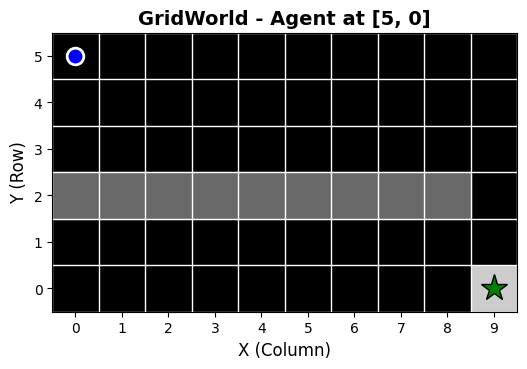

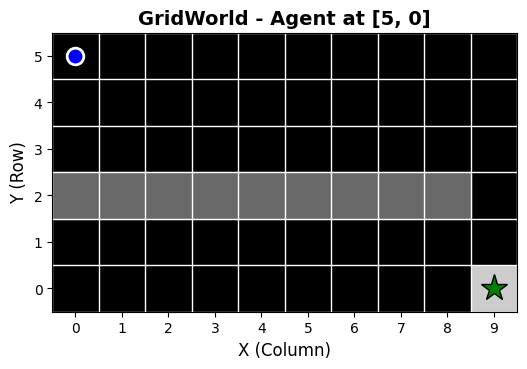

In [ ]:
# Training loop
initial_walls = [
    (2,0),(2,1),(2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8)
]
changed_walls = [
    (2,1),(2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8),(2,9)
]
# env0 = GridWorldEnv(grid_size=(6,10), start=(3,0), goal=(0,9), walls=initial_walls)
env1 = GridWorldEnv(grid_size=(6,10), start=(5,0), goal=(0,9), walls=initial_walls)
# env0.render()
env1.render()

Environment changed at episode 40
Environment changed at episode 40


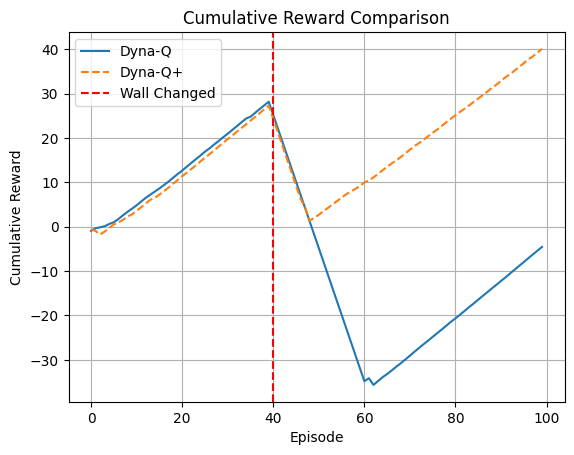

In [ ]:
# Training loop
initial_walls = [
    (2,0),(2,1),(2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8)
]
changed_walls = [
    (2,1),(2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8),(2,9)
]
env0 = GridWorldEnv(grid_size=(6,10), start=(5,0), goal=(0,9), walls=initial_walls)

# (a) Plain Dyna-Q
steps_q , rewards_q, _ = train_dyna_q_changing_walls(
        env0, planning_steps=5,
        num_episodes=100, visualize=False)


env1 = GridWorldEnv(grid_size=(6,10), start=(5,0), goal=(0,9), walls=initial_walls)
steps_qp, rewards_qp, _ = train_dyna_q_changing_walls(
        env1, planning_steps=5,
        num_episodes=100, visualize=False,
        agent_cls=DynaQPlusAgent,      # <-- use the new class
        kappa=1e-3)

# Plot Cumulative Rewards
plt.plot(np.cumsum(rewards_q), label='Dyna-Q')
plt.plot(np.cumsum(rewards_qp), label='Dyna-Q+', linestyle='--')
plt.axvline(x=40, color='red', linestyle='--', label='Wall Changed')
plt.title("Cumulative Reward Comparison")
plt.xlabel("Episode"); plt.ylabel("Cumulative Reward")
plt.legend(); plt.grid(True); plt.show()

##Observation :
```
Effect of Random Sampling in Sample Model in initialization
```
* if lucky , we hit the right old transition early ➡ agent re-explores quickly
* if unlucky , the agent keeps replaying newer transition ➡ slow to adapt

```
Effect of kappa
```
* small kappa ➡ Safe, but effect is minimal; may not re-explore fast enough
* medium kappa ➡ Balanced — bonus helps re-exploration without dominating
* large kappa ➡Agent over-trusts model bonus, may diverge from optimal path

## Prioritized Sweeping
* We sweep through the most important state-action pairs first — i.e., those most likely to impact learning.
* Instead of sampling model transitions randomly like in Dyna-Q, we prioritize them using a priority queue based on how surprising or important their update would be.

How is this done ??
```
1. take a real action , get (s,a , r, s')
2. Update the model, Model(s,a) = (r, s')
3. Compute the TD error (q_learning) (priority):
  * P =  |TD_error|
4. if P > threshold, we insert (s,a) in to PQueue
5. Then we enter the planning loop
  * while PQ is not empty:
    * (s,a) ⬅ first(PQueue)
    * (r,s') ⬅ Model[(s,a)]
    * Q(s,a) ⬅ Q learning update

    For all s_dash predicted to lead to s: # the transition that leads into s , for eg: Model(s_dash, a_dash) = (s, .)
      * r_dash ⬅ Model(s_dash,a_dash) that leads to s
      * P ⬅ |r_dash + gamma* max_a Q(s,a) - Q(s_dash,a_action)|
      if P > threshold:
        * insert (s_dash, a_dash) into PQueue with priority P

```
In the basic version of Sutton and barto , we only push the direct predecessors of s (current state) in to prioriy queue in planning.
* ie, Model(s_prev_, a_prev_) = (s,r)

  * **Real Experience** = we look Forward
  * **Planning** = we look Backward

  * Planning steps = number of (s, a) pairs popped from the priority queue
  * Updates propagate backward via predecessors

In [ ]:
import heapq # python built in priority queue module based on Classic heap data structure
# priority queue is a structure where elements are retrieved in order of prioriy not insertion
# heapq provides an enfficent way to maintain this order using heap
# better for dynamically changing data where you always need the top priority
# Sorting a list = inefficient when changes happen frequently

# PSEUDO CODE : NOT COMPLETE CODE;
class PrioritizedSweepingagent:
  def __init__(...)
      ....
      ....
      self.model ={}
      self.predecessors = defaultdict(set)  # s' :-> set of (s,a)

      self.priority_queue = []
      self.theta = 1e-5 # threshold for pushing into queue

  ...
  def update_model(self, state, action, reward, next_state):
      self.model[(state, action)] = (next_state, reward)
      self.time +=1
      self.last_visit[(state, action)] = self.time

      if next_state is not None:
          self.predecessors[next_state].add((state,action))
          """
          self.predecessors["S1"].add(("S0", "RIGHT"))
          self.predecessors["S1"].add(("S2", "DOWN"))

          ==>
          {
            "S1": { ("S0", "RIGHT"), ("S2", "DOWN") }
          }
          """
  ...
  def update_real(self, state, action, reward, next_state):
      ....
      ...
      td_error = td_target - self.Q[state[0], state[1], action]
      ...
      priority = abs(td_error)
      if priority > self.theta:
          heapq.heappush(self.prioriy_queue, (-priority, state,action))

  def planninng(self):
      n = self.planning_steps
      while self.priority_queue and n>0:
          _ , (s,a) = heapq.heapop(self.priority_queue)
          next_state, reward = self.model[(s, a)]

          # Q update
          ...
          td_error = td_target - self.Q[s[0], s[1], a]
          ...

          # for all predecessors of s
          for (s_prev  , a_prev) in self.predecessors[s]:
              s_next, r_prev = self.model[(s_prev, a_prev)]
              best_next = np.argmax(self.Q[s])
              pred_target = r_prev + self.gamma * self.Q[s[0], s[1], best_next]
              td_error = abs(pred_target - self.Q[s_prev[0], s_prev[1], a_prev])

              if pred_error > self.theta:
                heapq.heappush(self.priority_queue, (-td_error, (s_prev, a_prev)))
                # heap is a min-heap by default: smallest item gets popped first, we want larget TD error, so negate it
                """
                heap = []
                heapq.heappush(heap, (-5.0, ("s1", "a1")))
                heapq.heappush(heap, (-2.0, ("s2", "a2")))
                heapq.heappop(heap) :-> gives us (-5.0, ("s1", "a1")) — highest priorit

                """
            n-=1

#Section 8.5 : Expected vs Sample Updates

** Sample Update** (used in Q-learning/DynaQ):
* Uses a single outcome from interaction or simulation:
* Faster , more variance , works without full model
* **Expected update costs more per step**

** Expected Update** (used in Dynamic Programming):
* Uses a full expectation over next states:
* slower , less variance , needs full model
* **Sample updates are cheaper and can be repeated more times**

Expected updates are better in terms of single-update accuracy

But sample updates are better in terms of total learning per unit of computation — especially in large state spaces

# Trajectory Sampling

* Here we instead of going only few planning step in sample, we actualy go full episode following a policy (eg: e-greedy policy) in the model , ie simulate a full tragectory , and perform TD/Q-learning updates along the way
* Planning step = one whole simulated episode



# Decision Time planning
Traditional Planning (like Dyna)
* Plan in the background all the time
* Keeps refining Q-table everywhere
* Planning is state-independent

Decision Time planning
* A form of model-based planning that is done **right before making a decision**
* It focuses computation on the **current state**, rather than sweeping across all states
* Especially useful in large or dynamic environments
* Planning happens before taking next actions

Decision-Time planning is not about improving your policy everywhere , its about using limited time to make the best next move
  * it shifts focus from long-term learning to short-term optimal decisions.
  - More efficient use of limited compute
  - Better decisions in the short term
  - Easier to apply in real-time systems

Techiniques used for Decision Time planning
1. Rollouts/Simulations
  * At decision time, simulate trajectories from current state
  * Use Monte Carlo sampling or Q-Learning updates
  * eg : Monte Carlo Tree Search (MCTS)
2. Lookahead Search
  * Build a tree of possible future actions from current state
  * Use model to evaluate likely future states
  * Choose action with best exptected outcomes

```
# How do we get a model?
```
There are two common approaches:

1. Model is Known

This is common in:

* Simulated environments

* Games (e.g., Chess, Go, Atari) , Physics based simulation

* Control problems where dynamics are known

In this case:

* You already know P(s'|s,a) and R(s,a,s')

* You can plan directly from the start

This is often used in decision-time planning like Monte Carlo Tree Search (MCTS)


# Forward Search Algorithm

From current state ➡ lookahead and take all possible action and follow a certain planning steps or till terminal states, calculate a accumulated return , then choose the action with highest return
- Builds a tree of future actions using the model
- Evaluates paths via simulation or backups

**Heuristic Search** = Forward search with some additional constraints

- Adds a heuristic to bias which branches to explore
- May stop early, prune, or guide simulation depth
- A smarter, constrained version of forward search

# Rollout Algorithm
- A decision-time planning algorithm
- Simulates full episodes in a model
- Starts with each possible action from current state
- Uses a base policy to complete the episode
- Picks the action with highest expected return

### Why use it?

- Simple to implement
- Scales to large state spaces
- Doesn't require building a full Q-table

### Where is it used?

- Monte Carlo Tree Search (MCTS)
- AlphaZero
- Model-based RL (e.g., Dreamer, PlaNet)

```
“From state S, you took an action A1, then follow a policy and complete an episode...”
✔️ Correct – You simulate an episode starting with action A1, then use a base policy (like ε-greedy or even random) for the rest of the steps in the simulated environment.

“Then choose the same action A1 again, then follow same policy and complete another episode...”
✔️ Correct again – You repeat this multiple times to average out randomness (like in Monte Carlo estimation).

“Then take another action A2 from state S, repeat the same process...”
✔️ Exactly – you do the same for all actions available from state S.

“Then check which one gives the best average return, then take that action...”
✔️ Yes – that’s the key decision-time planning step:
Pick the best action based on simulated return, not just from Q-values.

“...then move to the next state, and repeat same process for taking next action”
✔️ Yes – this is repeated at each decision point during actual execution.


1. For each action a1, a2, a3 , ...an from state S:
 * Simulate many episodes starting with action ai
 * Follow a default policy (like random or ε-greedy) until the end (or for N steps)
 * Record the total return (reward
2. Average the returns for each ai, and choose the one with highest average

```
```
"**Try all options from this state by simulating full episodes. Then go with the one that worked best on average.**""
```

```
for action in actions_from(state):
    returns = []
    for _ in range(num_rollouts):
        total_reward = simulate_episode(state, action, base_policy)
        returns.append(total_reward)
    avg_return[action] = mean(returns)

best_action = argmax(avg_return)

```
Rollouts Are Computationally Heavy:

In a 4-action GridWorld:

* From state s, you try 4 actions

* For each action, simulate 20 episodes

* Each episode lasts ~30 steps

You simulate:

* 4 actions x 20 episodes x 30 steps = 2400 simulated 1 steps
just to choose 1 action!


# Rollout (with limited depth)
- Simulate N steps into the future using a given policy

- For each initial action, do multiple rollouts (episodes)

- Take the average return over those rollouts

- Choose the action with highest average return

- 🔁 Stochastic and averaged

#  Forward Search (with depth N)
- Simulate a tree of depth N from current state

- Evaluate outcomes recursively (e.g., via Bellman backup or value estimates)

- Usually does not involve running full episodes

- Focuses on expected return from a deterministic expansion of possible actions

- 🧠 Deterministic and exhaustive (for low branching factor)

# Monto Carlo Tree Search Algorithm (MCTS)
MCTS also simulates episodes, but builds a search tree during the process.
1. Select a promising node using past stats (via tree policy like UCB).
2. Expand one new child node (try a new action).
3. Simulate from that node using a default policy.
4. Backpropagate the simulation result to all parent nodes.